# NIST PREP Summer 2020

- This is a summary of my accomplishments in the NIST PREP program
- Data was obtained from the Windover Group, NIST Gaithersburg

- loading standard Python packages and enabling plotting

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- include custom gaussian for simple gaussian fits
- include custom bruker_io toolbox
- include custom Spectrum_Evaluation toolbox
- include HyperSpy for peak fitting


In [2]:
import gaussian
import bruker_io as brio
import spectrum_evaluation as se
import hyperspy.api as hs


- import XRF data from a *.txt

In [3]:
Mo_acryl = brio.FittingData(os.path.join('Acrylic', '20170510_D1_Mo_50kv_100mA_acryl 0_python.txt'))
brio.bruker_txt_import(Mo_acryl)

import size:  (4096,)


- plot spectrum data from *.txt file

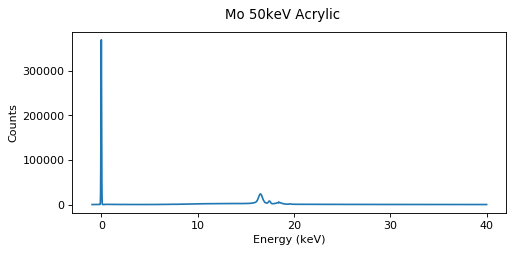

In [4]:
fig = plt.figure(num=None, figsize=(7, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Mo_acryl.energy_scale, Mo_acryl.channels)
fig.suptitle('Mo 50keV Acrylic')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

- import XRF data from a *.spx file

In [5]:
Ti = brio.FittingData(os.path.join('Trials', 'Element B Ti.spx'))
brio.bruker_spx_import(Ti)

- plot spectrum data from *.spx file

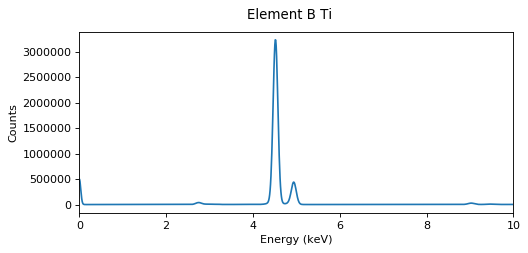

In [6]:
fig = plt.figure(num=None, figsize=(7, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Ti.energy_scale, Ti.channels)
fig.suptitle('Element B Ti')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.xlim(0, 10)
plt.show()

- plot spectrum data with peak lines using hyperspy from a *.spx file

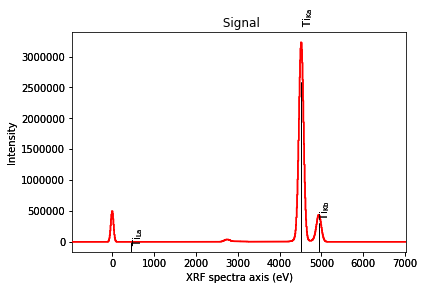

In [18]:
Ti_XRF = hs.signals.EDSSEMSpectrum(Ti.channels)
Ti_XRF.set_microscope_parameters(50000)
Ti_XRF.axes_manager[0].name = 'XRF spectra'
Ti_XRF.axes_manager[0].offset = Ti.calibration_abs
Ti_XRF.axes_manager[0].scale = Ti.calibration_lin
Ti_XRF.axes_manager[0].units = 'eV'
Ti_XRF.add_elements(['Ti'])
Ti_XRF.crop_signal1D(0, 800)
Ti_XRF.plot(True)

- fit a gaussian to a specific peak in a sample

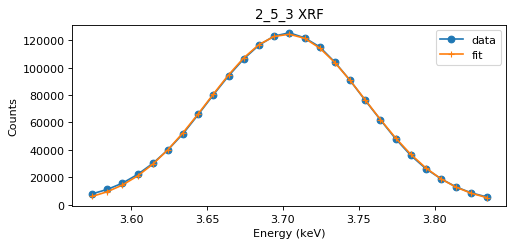

In [7]:
gaussian.glass("2_5_3", 453, 480)

- use spectrum evaluation to fit a sample

In [8]:
elements = ['Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'Fe', 'Sr', 'Rh']
directory = os.path.join('Glass', 'Map')
ROI, model = se.spectra_fit(directory, "leastsq", "ls", elements)


['Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'Fe', 'Sr', 'Rh']
Map.spx


- demonstrating spectra fit with plots

In [9]:
elements = ['Bi']
directory = os.path.join('Trials', 'SE')
directory_path = directory
fitter = "leastsq"
method = "ls"
files = []
spx_files = []
roi_data = elements
model_data = elements
print(elements)
life_time_in_ms = []
for (dirpath, dirnames, filenames) in os.walk(directory_path):
    files.extend(filenames)
    break
for file in files:
    if '.spx' in file:
        spx_files.append(file)

['Bi']


- plotting the hsEDS values

Element B Bi.spx
NOTE: Number of channels is 4094, instead of the default 4096.


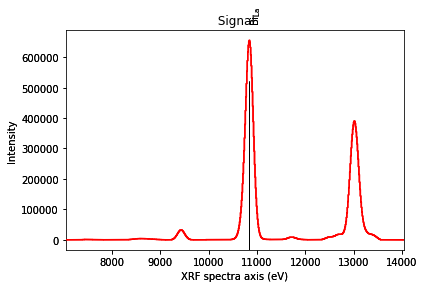

In [12]:
for file in spx_files:
    print(file)
    spx_file = file
    spx = brio.FittingData(directory_path + '/' + spx_file)
    brio.bruker_spx_import(spx)
    se.pulse_pileup_removal(spx)
    se.SCALEDSNIP(spx)
    se.polycap_remove(spx)
    hsEDS = hs.signals.EDSSEMSpectrum(spx.channels)
    hsEDS.set_microscope_parameters(50000)
    hsEDS.axes_manager[0].name = 'XRF spectra'
    hsEDS.axes_manager[0].offset = spx.calibration_abs
    hsEDS.axes_manager[0].scale = spx.calibration_lin
    hsEDS.axes_manager[0].units = 'eV'
    hsEDS.add_elements(elements)
    hsEDS.add_lines()
    line_names = hsEDS.metadata.Sample.xray_lines
    hsEDS.crop_signal1D(800, 1500)
    hsEDS.plot(True)

- plotting the model data

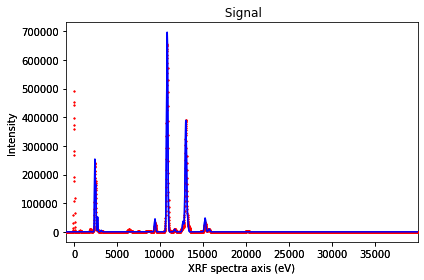

In [11]:
    mod = hsEDS.create_model()
    mod.remove('background_order_6')
    new_roi = np.zeros(len(elements))
    new_model = np.zeros(len(elements))
    mod.fit(fitter=fitter, method=method)
    for i in np.arange(len(elements)):
        new_roi[i] = np.float(hsEDS.get_lines_intensity([line_names[i]])[0].data[0])
        model_call = ''.join(['mod.components.', line_names[i], '.A.value'])
        new_model[i] = eval(model_call)
        # test_param[i] = ''.join(['mod.components.', line_names[i], '.A.value'])
        # new_model[i]= np.float(test_param)
    # Hf_La_model.append(np.float())
    # Si_Ka_model.append(np.float(mod.components.Si_Ka.A.value))
    # Hf_Si_ratio.append(np.float(mod.components.Hf_La.A.value)/np.float(mod.components.Si_Ka.A.value))
    life_time_in_ms.append(spx.life_time_in_ms)
    roi_data = np.vstack((roi_data, new_roi))
    model_data = np.vstack((model_data, new_model))

    mod.plot()

